# Panic Disorder Prediction using Machine Learning

This notebook explores the development of a machine learning model to predict the likelihood of panic disorder in individuals based on a variety of demographic, behavioral, and clinical factors. The analysis includes data preprocessing, exploratory analysis, feature engineering, and predictive modeling using classification algorithms.

## Importing Libraries

We start by importing all the essential libraries for data manipulation, visualization, model building, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Loading the Dataset

We load the panic disorder dataset and set the `Participant ID` column as the index to uniquely identify each record.

In [ ]:
df = pd.read_csv("panic_disorder_dataset.csv")
df.set_index('Participant ID', inplace=True)

In [ ]:
num_rows, num_columns = df.shape
print(f'The CSV file has {num_rows} rows and {num_columns} columns.')

The CSV file has 120000 rows and 16 columns.


## Dataset Overview

We check the overall shape of the dataset to understand its size and dimensionality.

In [ ]:
print(df.head())

                Age  Gender Family History Personal History Current Stressors  \
Participant ID                                                                  
1                38    Male             No              Yes          Moderate   
2                51    Male             No               No              High   
3                32  Female            Yes               No              High   
4                64  Female             No               No          Moderate   
5                31    Male            Yes               No          Moderate   

                           Symptoms  Severity Impact on Life Demographics  \
Participant ID                                                              
1               Shortness of breath      Mild           Mild        Rural   
2                     Panic attacks      Mild           Mild        Urban   
3                     Panic attacks      Mild    Significant        Urban   
4                        Chest pain  Moderate  

##  Checking for Missing and Duplicate Values

We identify columns with missing data and count the number of duplicate records in the dataset. This is an essential step before data cleaning.

In [ ]:
print("Missing values:")
print(df.isnull().sum())

print("Duplicate values:")
print(df.duplicated().sum())

Missing values:
Age                             0
Gender                          0
Family History                  0
Personal History                0
Current Stressors               0
Symptoms                        0
Severity                        0
Impact on Life                  0
Demographics                    0
Medical History             30174
Psychiatric History         29910
Substance Use               39991
Coping Mechanisms               0
Social Support                  0
Lifestyle Factors               0
Panic Disorder Diagnosis        0
dtype: int64
Duplicate values:
50


In [ ]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
print("Missing values after handling:")
print(df.isnull().sum())

print("\nDuplicate values after handling:")
print(df.duplicated().sum())

Missing values after handling:
Age                         0
Gender                      0
Family History              0
Personal History            0
Current Stressors           0
Symptoms                    0
Severity                    0
Impact on Life              0
Demographics                0
Medical History             0
Psychiatric History         0
Substance Use               0
Coping Mechanisms           0
Social Support              0
Lifestyle Factors           0
Panic Disorder Diagnosis    0
dtype: int64

Duplicate values after handling:
0


## Chi-Square Test for Categorical Variables

We perform the Chi-Square test to examine the statistical association between each categorical feature and the target variable (`Panic Disorder Diagnosis`).


In [ ]:
chi2_results = {}
target_column = 'Panic Disorder Diagnosis'
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    contingency_table = pd.crosstab(df[target_column], df[col])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = {'Chi2': chi2, 'P-value': p}

print("\nChi-square test results:")
for col, result in chi2_results.items():
    print(f"{col}: Chi2={result['Chi2']}, P-value={result['P-value']}")


Chi-square test results:
Gender: Chi2=0.02063962731071392, P-value=0.8857650238866819
Family History: Chi2=538.0542736469783, P-value=4.997152155282144e-119
Personal History: Chi2=665.2598976339607, P-value=1.0726121649379595e-146
Current Stressors: Chi2=3659.7470134740342, P-value=0.0
Symptoms: Chi2=1671.9312299389148, P-value=0.0
Severity: Chi2=1501.8833830419267, P-value=0.0
Impact on Life: Chi2=1948.4030506223892, P-value=0.0
Demographics: Chi2=124.4307701920374, P-value=6.780394662469932e-29
Medical History: Chi2=96.17024655917315, P-value=1.308869350466466e-21
Psychiatric History: Chi2=57.668384221291134, P-value=3.002406393432515e-13
Substance Use: Chi2=25.611331906563073, P-value=4.1757990269588947e-07
Coping Mechanisms: Chi2=628.7326627171059, P-value=5.947016904751294e-136
Social Support: Chi2=97.87901125377797, P-value=5.569840505560957e-22
Lifestyle Factors: Chi2=10765.797967238534, P-value=0.0


In [ ]:
df.drop(columns=['Gender'], inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

## Label Encoding Categorical Variables

Each categorical feature is encoded into numeric format using `LabelEncoder`, preparing the dataset for model training.


In [ ]:
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = label_encoder.fit_transform(df[column])

In [ ]:
X = df.drop(columns=['Panic Disorder Diagnosis'])
y = df['Panic Disorder Diagnosis']

## One-Hot Encoding Categorical Variables

We apply one-hot encoding to represent categorical variables as binary vectors, allowing them to be used in machine learning algorithms.


In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

In [ ]:
X.reset_index(drop=True, inplace=True)
X = pd.concat([X, X_encoded], axis=1)

## Class Distribution Visualization

We visualize the class balance of the target variable to assess if the dataset is imbalanced.


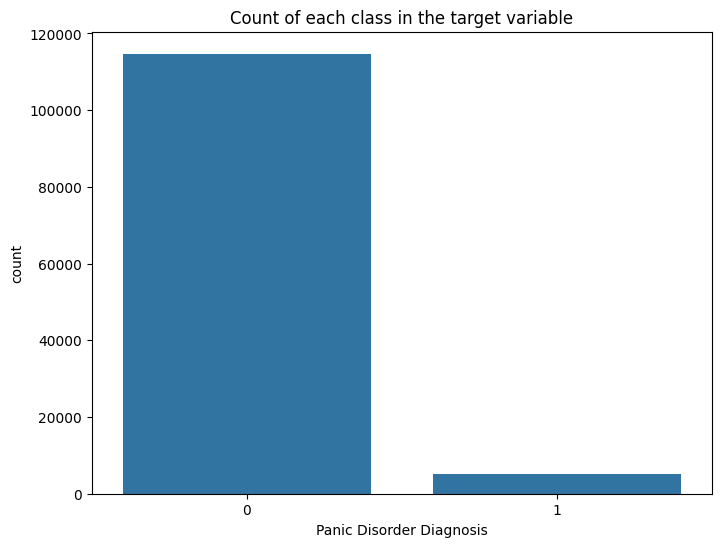

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Panic Disorder Diagnosis', data=df)
plt.title('Count of each class in the target variable')
plt.show()

## Correlation Heatmap

This heatmap helps visualize relationships among numerical features and their correlation with the target variable.


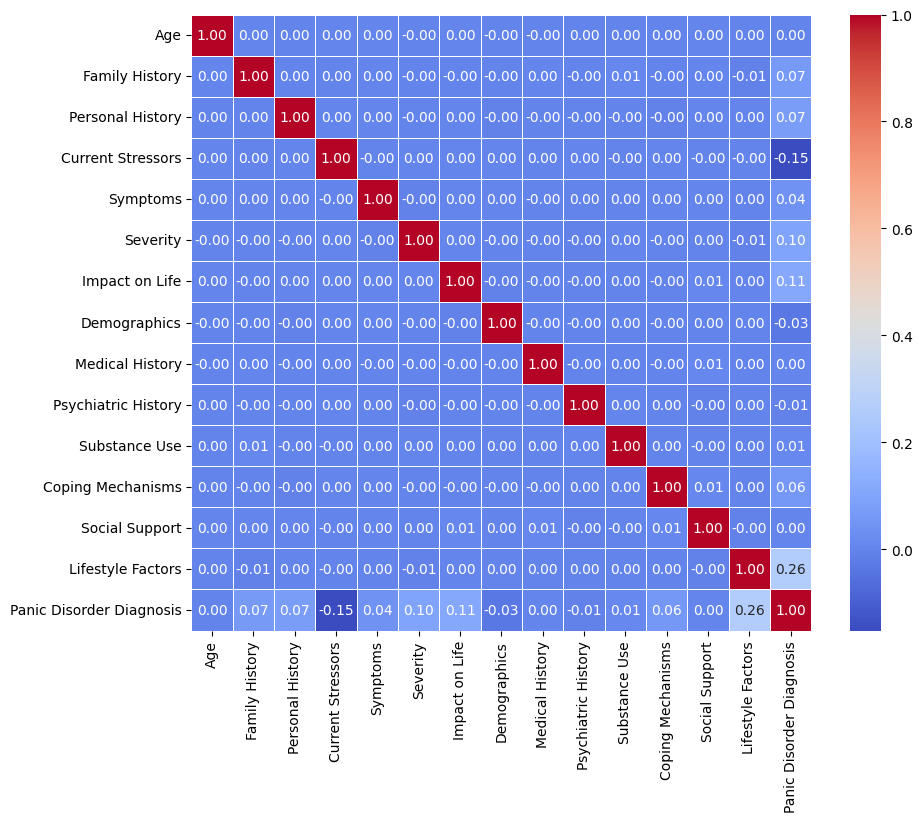

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

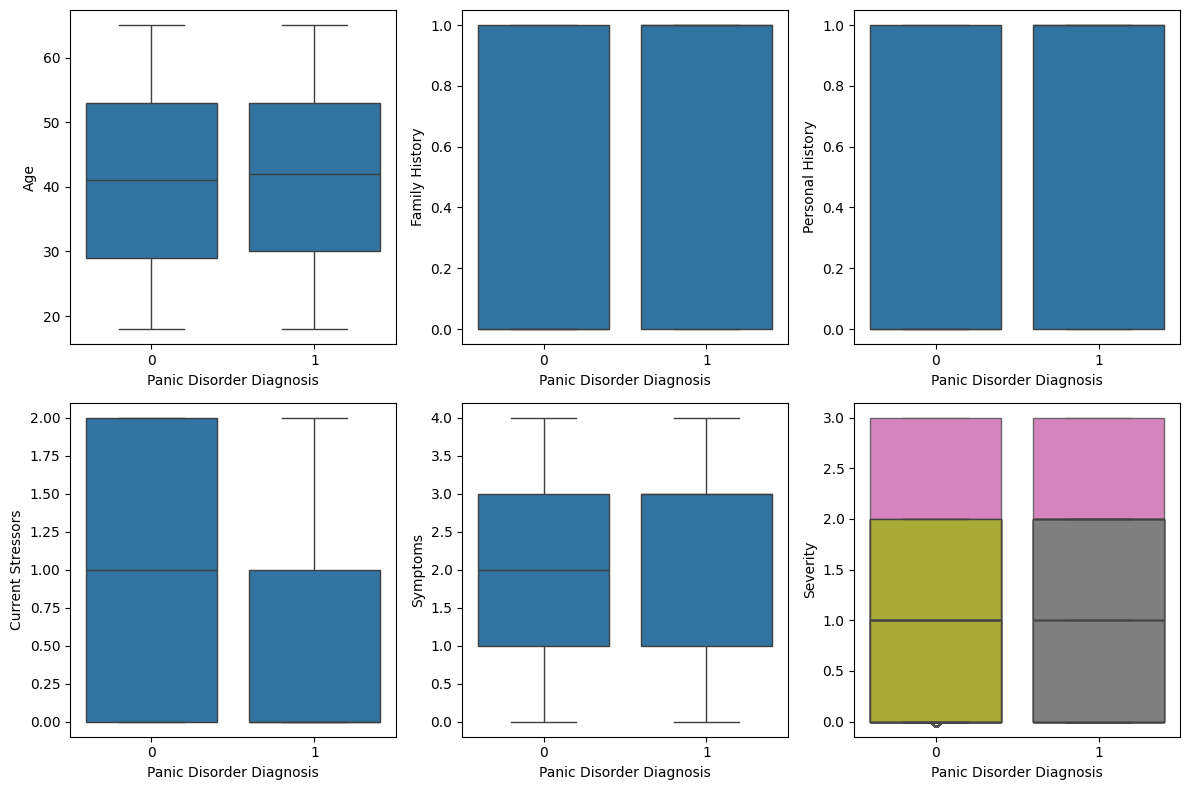

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(2, 3, min(i+1, 6))
    sns.boxplot(x='Panic Disorder Diagnosis', y=col, data=df)
plt.tight_layout()

## Train-Test Split & Class Balancing (SMOTE)

We split the dataset and apply SMOTE to balance the minority and majority classes in the training data.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

## Model Training

We train logistic regression, Random Forest, Decision Tree and XGBoost models to classify panic disorder cases and evaluate its performance using accuracy, classification report, confusion matrix, and ROC-AUC curve.


Logistic Regression:
Accuracy: 0.9642022696929239

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     22908
           1       0.60      0.59      0.59      1060

    accuracy                           0.96     23968
   macro avg       0.79      0.78      0.79     23968
weighted avg       0.96      0.96      0.96     23968


Confusion Matrix:
 [[22487   421]
 [  437   623]]


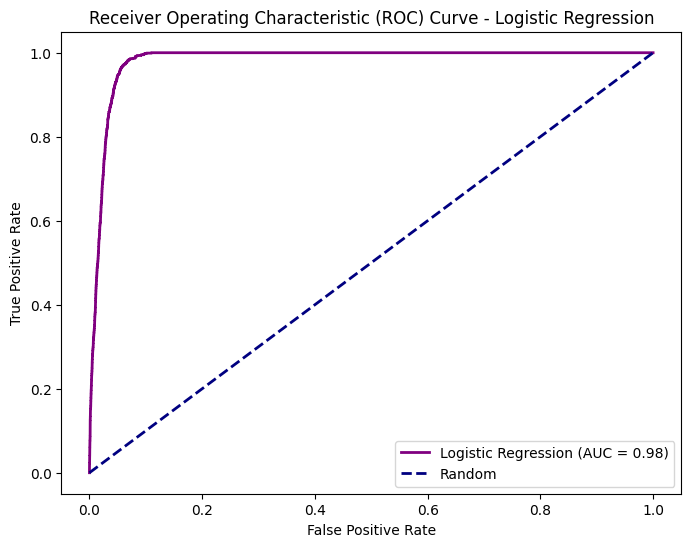

In [ ]:
llogistic_model = LogisticRegression(random_state=42, max_iter=10000)
logistic_model.fit(X_resampled_scaled, y_resampled)

y_logistic_pred = logistic_model.predict(X_test_scaled)
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_logistic_pred))
print("\nClassification Report:\n", classification_report(y_test, y_logistic_pred))

conf_matrix = confusion_matrix(y_test, y_logistic_pred)
print("\nConfusion Matrix:\n", conf_matrix)

y_prob_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='purple', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

/home/students/debpal/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


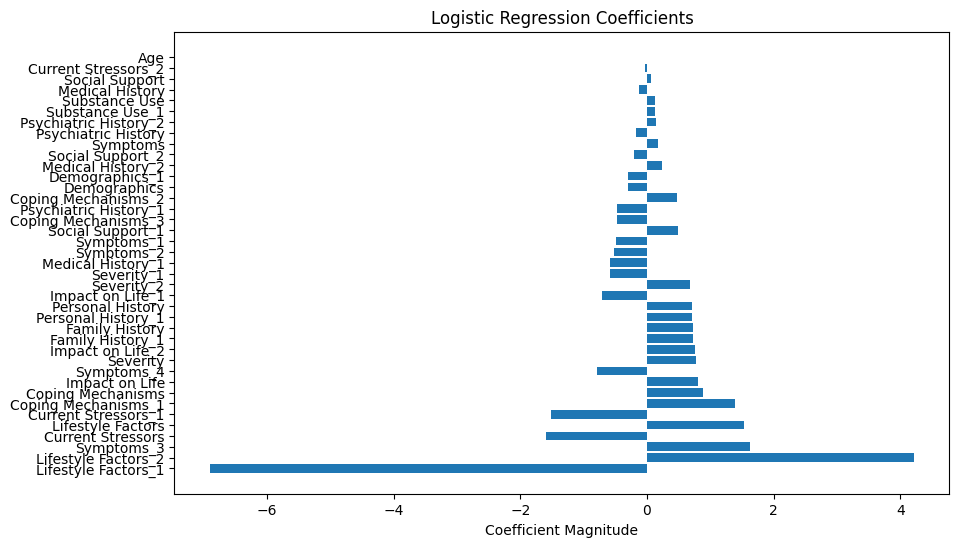

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

coefficients = logreg.coef_[0]
feature_names = X_train.columns.tolist()

coefficients_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

coefficients_df["Magnitude"] = np.abs(coefficients)

coefficients_df.sort_values("Magnitude", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"])
plt.xlabel("Coefficient Magnitude")
plt.title("Logistic Regression Coefficients")
plt.show()



Random Forest:
Accuracy: 0.9999582777036048

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22908
           1       1.00      1.00      1.00      1060

    accuracy                           1.00     23968
   macro avg       1.00      1.00      1.00     23968
weighted avg       1.00      1.00      1.00     23968


Confusion Matrix:
 [[22907     1]
 [    0  1060]]


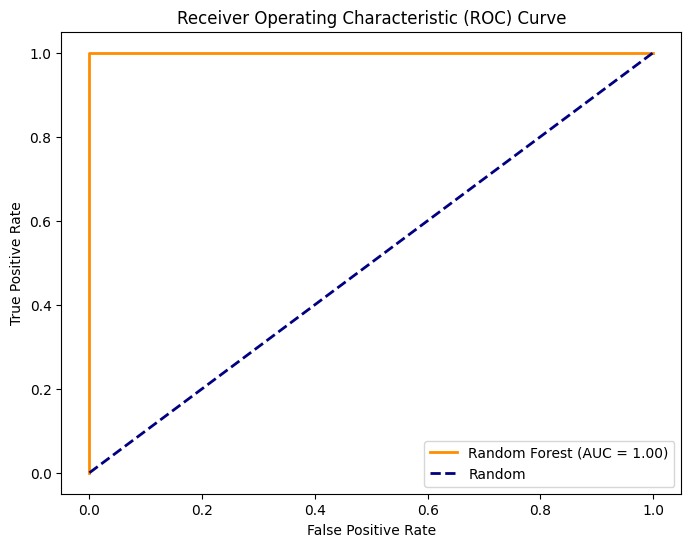

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_resampled_scaled, y_resampled)

y_rf_pred = rf_model.predict(X_test_scaled)

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_rf_pred))
print("\nClassification Report:\n", classification_report(y_test, y_rf_pred))

conf_matrix_rf = confusion_matrix(y_test, y_rf_pred)
print("\nConfusion Matrix:\n", conf_matrix_rf)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Decision Tree:
Accuracy: 0.9999582777036048

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22908
           1       1.00      1.00      1.00      1060

    accuracy                           1.00     23968
   macro avg       1.00      1.00      1.00     23968
weighted avg       1.00      1.00      1.00     23968


Confusion Matrix:
 [[22908     0]
 [    1  1059]]


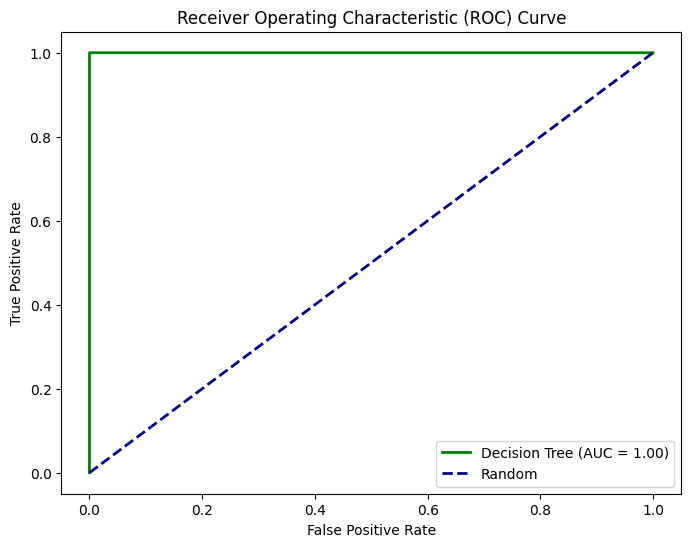

In [ ]:

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_resampled_scaled, y_resampled)

y_dt_pred = dt_model.predict(X_test_scaled)

print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_dt_pred))
print("\nClassification Report:\n", classification_report(y_test, y_dt_pred))

conf_matrix_dt = confusion_matrix(y_test, y_dt_pred)
print("\nConfusion Matrix:\n", conf_matrix_dt)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



XGBoost:
Accuracy: 0.9955357142857143

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22908
           1       0.93      0.97      0.95      1060

    accuracy                           1.00     23968
   macro avg       0.96      0.99      0.97     23968
weighted avg       1.00      1.00      1.00     23968


Confusion Matrix:
 [[22829    79]
 [   28  1032]]


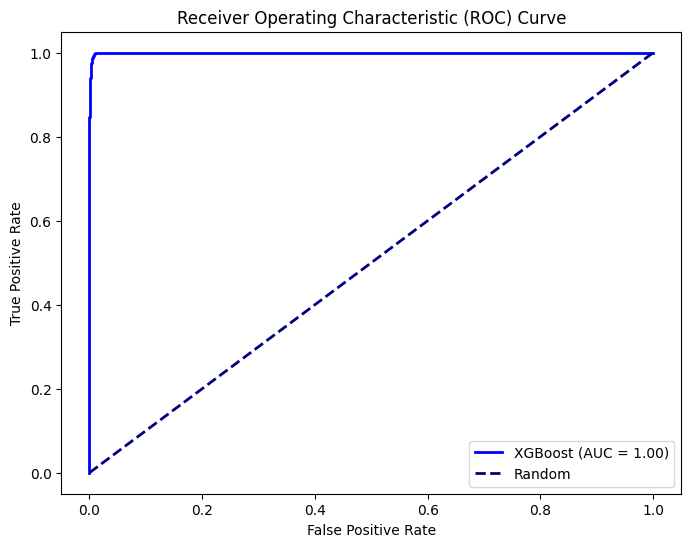

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

xgb_model.fit(X_resampled_scaled, y_resampled)

y_xgb_pred = xgb_model.predict(X_test_scaled)

print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, y_xgb_pred))

conf_matrix_xgb = confusion_matrix(y_test, y_xgb_pred)
print("\nConfusion Matrix:\n", conf_matrix_xgb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()